In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures, normalize
from scipy.stats import pearsonr
from scipy.io import savemat

In [2]:
tab = pd.read_csv("temp_desL_init_zerosubset.csv")

In [3]:
tab = tab.loc[:, ["h", "f", "l", "p", "r", "s", "vsSel"]]

In [4]:

pf = PolynomialFeatures(2, interaction_only = True)

In [5]:
X = np.array(tab.loc[:, ["h", "f", "l", "p", "r", "s"]])
X

array([[1, 4, 5, 9, 9, 9],
       [1, 4, 6, 9, 8, 9],
       [1, 4, 6, 9, 9, 9],
       ...,
       [9, 6, 1, 8, 2, 1],
       [9, 6, 1, 9, 1, 1],
       [9, 6, 1, 9, 2, 1]])

In [6]:
def expand_x(X):
    Xi = np.hstack([X] + [(X >= i) + 0 for i in np.arange(2, 10)])
    return Xi

Xi = expand_x(X)

In [7]:
ofs = ["h", "f", "l", "p", "r", "s"]
featnames1 = np.concatenate([ofs] + list([['I(' + of + '>=' + str(i) + ')' for i in np.arange(2, 10)] for of in ofs]))


In [8]:
#X2 = normalize(pf.fit_transform(Xi))
X2 = pf.fit_transform(Xi)
featnames2 = np.array(['*'.join(featnames1[np.nonzero(row)[0]]) for row in pf.powers_])
X2.shape


(34520, 1486)

In [9]:
y = tab.vsSel.values

In [10]:
n = len(y)
ntrain = int(n/2)
nval = int(n * .6)
nval

20712

In [11]:
from numpy.random import choice
perm = choice(n, n, replace = False)

In [12]:
Xtr = X2[perm[:ntrain]]
Xtv = X2[perm[ntrain:nval]]
Xte = X2[perm[nval:]]
ytr = y[perm[:ntrain]]
ytv = y[perm[ntrain:nval]]
yte = y[perm[nval:]]


In [13]:
from sklearn.linear_model import ElasticNet, LinearRegression

In [14]:
#lm = ElasticNet(alpha = 1e-3, l1_ratio = 1.0)
lm = LinearRegression(positive = True)

In [59]:
#lm.fit(Xtr, ytr)
lm.fit(np.vstack([Xtr, 2 * np.ones((1, Xtr.shape[1]))]),  np.concatenate([ytr, [0]]))

LinearRegression(positive=True)

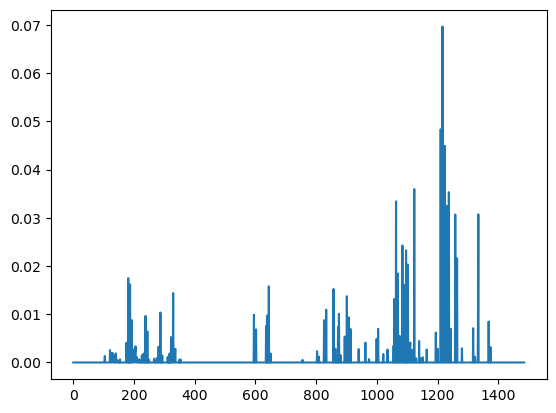

In [60]:
plt.plot(lm.coef_)

In [61]:
np.sum(lm.coef_ > 0)

147

In [62]:
lm.intercept_

-0.4749745769772836

In [63]:
pearsonr(ytv, lm.predict(Xtv))[0]

0.9067260936705557

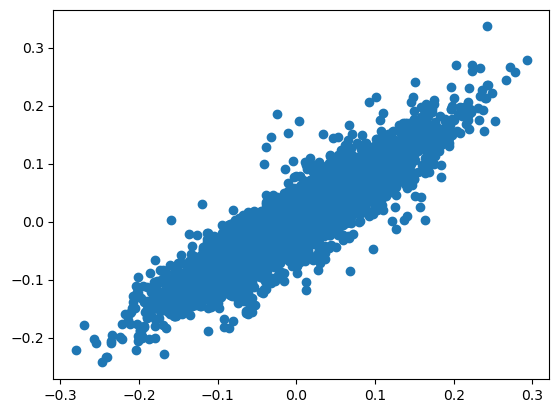

In [64]:
plt.scatter(ytv, lm.predict(Xtv))

In [65]:
pf.powers_.shape

(1486, 54)

In [66]:
pd.DataFrame({'feat':featnames2[lm.coef_ > 0], 'coef':lm.coef_[lm.coef_ > 0]}).to_csv("temp_desL_coefs.csv")

## interpret effects

In [67]:
order0_fx = lm.intercept_

In [68]:
# interpret effects by constructing test matrices
order1_fx = np.zeros((6, 10))
for i in range(6):
    test0 = np.zeros((10, 6))
    test0[:, i] = np.arange(10)
    testX = pf.fit_transform(expand_x(test0))
    order1_fx[i, :] = lm.predict(testX) - order0_fx

0

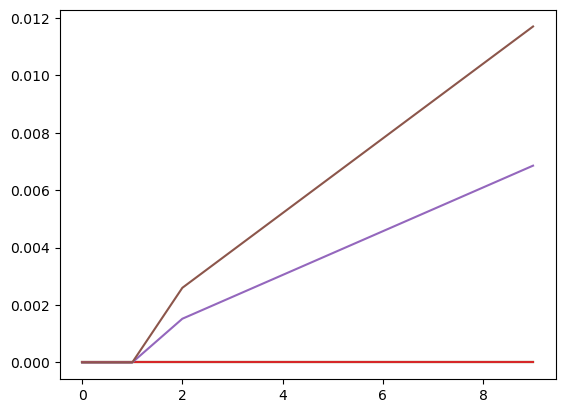

In [69]:
plt.plot(np.array(order1_fx).T)
0

In [70]:
order2_fx = np.zeros((6,6,10,10))

In [71]:
order2_fx.shape

(6, 6, 10, 10)

In [72]:
for i in range(6):
    for j in range(6):
        for v_i in range(1, 10):
            test0 = np.zeros((10, 6))
            test0[:, i] = v_i
            test0[:, j] = np.arange(10)
            testX = pf.fit_transform(expand_x(test0))
            order2_fx[i,j,v_i,:] = lm.predict(testX) - order0_fx - order1_fx[i, v_i] - order1_fx[j, :]

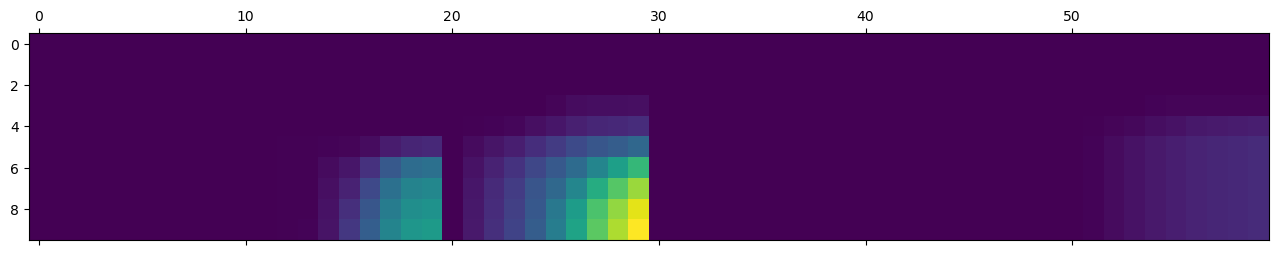

In [73]:
plt.matshow(np.hstack([order2_fx[0, i, :, :] for i in range(6)]))

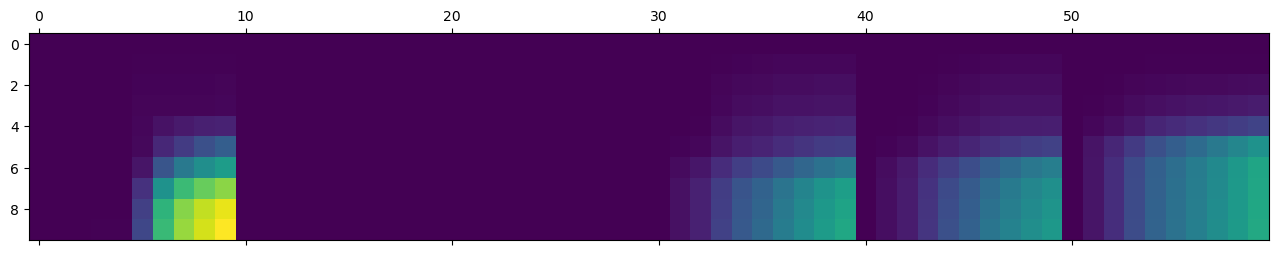

In [74]:
plt.matshow(np.hstack([order2_fx[1, i, :, :] for i in range(6)]))

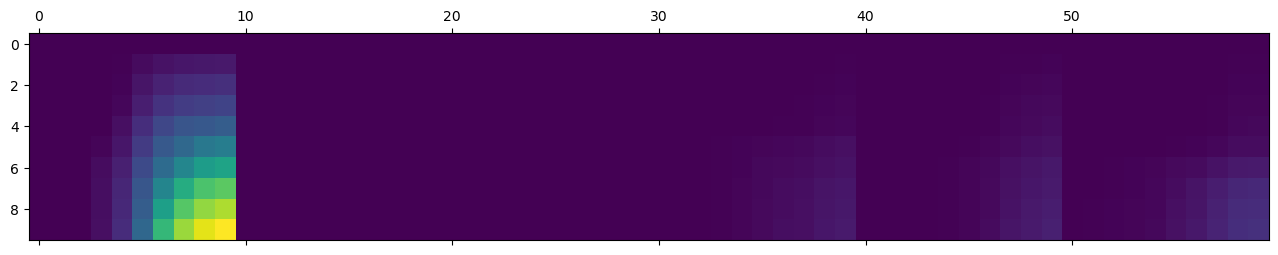

In [75]:
plt.matshow(np.hstack([order2_fx[2, i, :, :] for i in range(6)]))

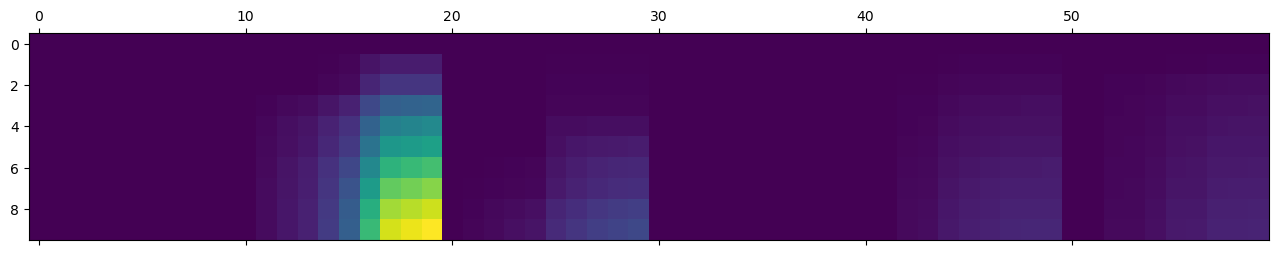

In [76]:
plt.matshow(np.hstack([order2_fx[3, i, :, :] for i in range(6)]))

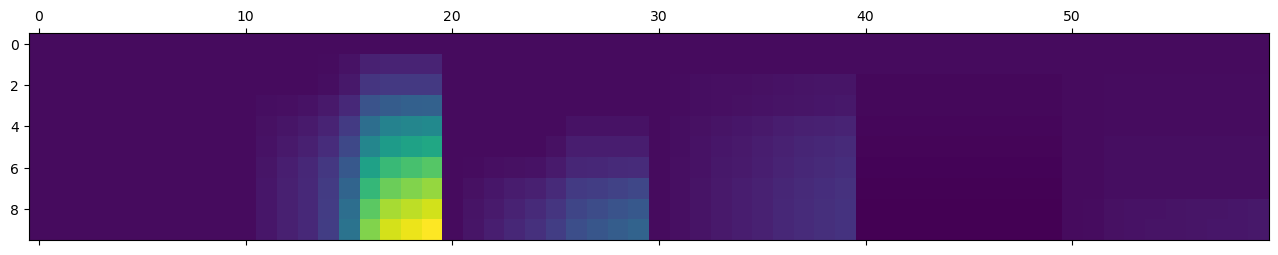

In [77]:
plt.matshow(np.hstack([order2_fx[4, i, :, :] for i in range(6)]))

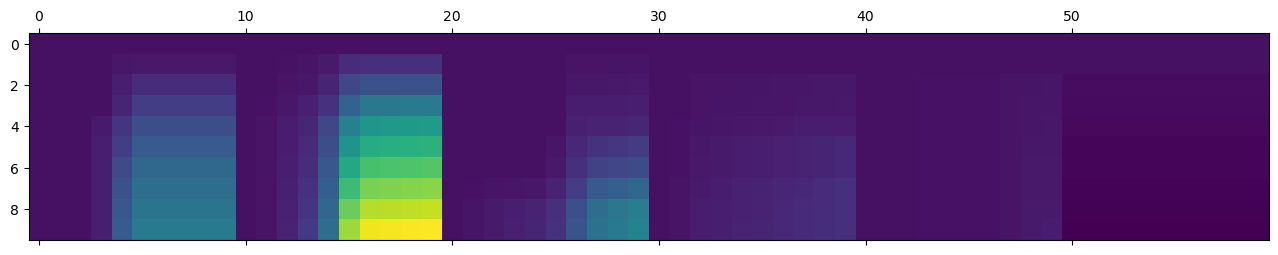

In [78]:
plt.matshow(np.hstack([order2_fx[5, i, :, :] for i in range(6)]))

In [79]:
def predict_x(x, f0, f1, f2):
    s = f0
    for i in range(6):
        s += f1[i,int(x[i])-1]
    for i in range(5):
        for j in range(i+1, 6):
            s += f2[i,j,int(x[i]),int(x[j])]
    return s

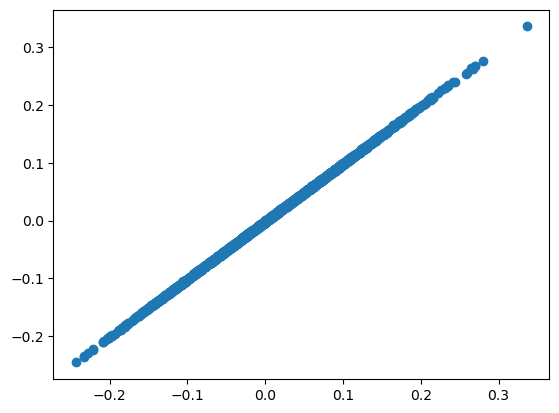

In [80]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]))

In [81]:
savemat("temp_desL_regress.mat", {"b0": order0_fx, "b1": order1_fx, "b2": order2_fx})

## Try discretization

In [82]:
delta = 0.01

In [83]:
f0 = np.floor(order0_fx/delta) * delta
f1 = np.floor(order1_fx/delta) * delta
f2 = np.floor(order2_fx/delta) * delta


0

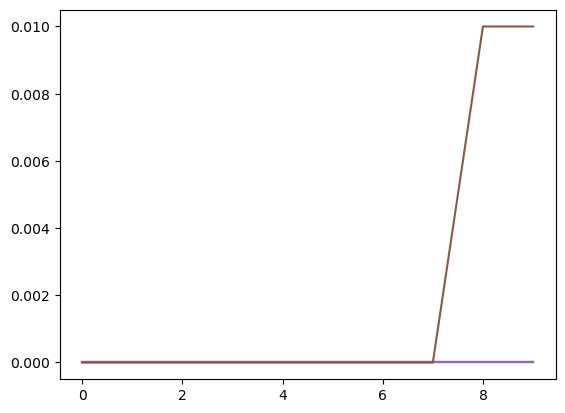

In [84]:
plt.plot(np.arange(0, 10), np.array(f1).T)
0

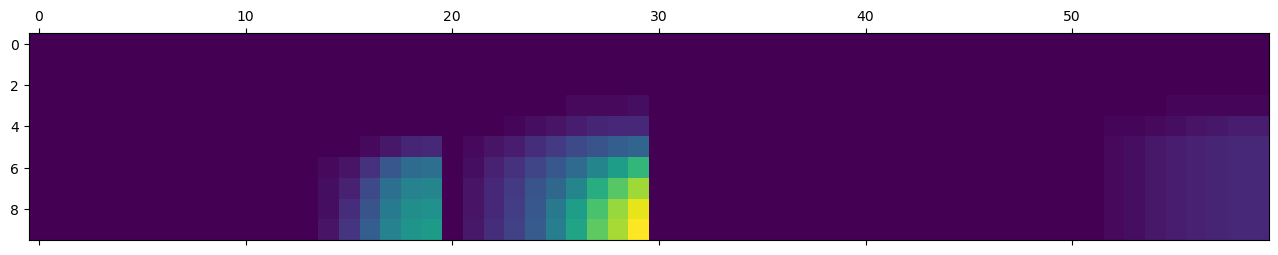

In [85]:
plt.matshow(np.hstack([f2[0, i, :, :] for i in range(6)]))

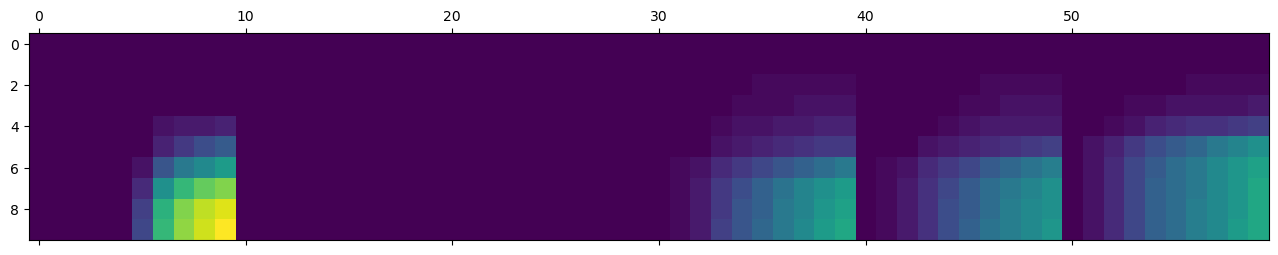

In [86]:
plt.matshow(np.hstack([f2[1, i, :, :] for i in range(6)]))

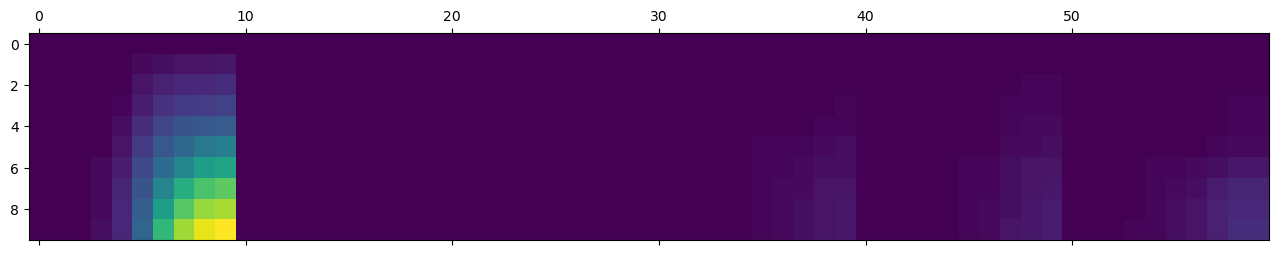

In [87]:
plt.matshow(np.hstack([f2[2, i, :, :] for i in range(6)]))

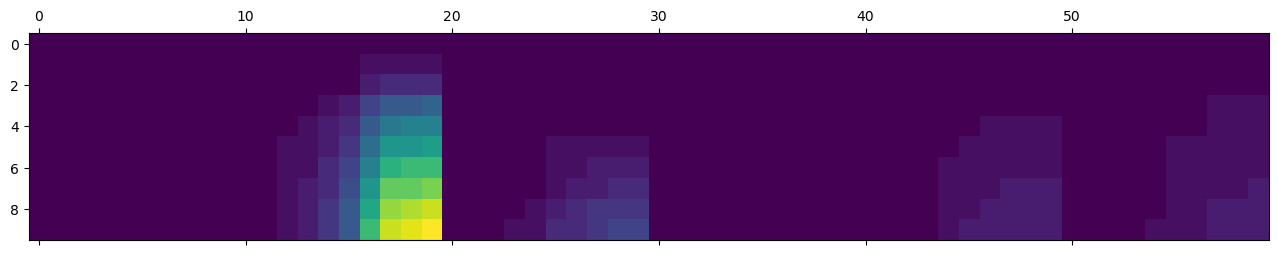

In [88]:
plt.matshow(np.hstack([f2[3, i, :, :] for i in range(6)]))

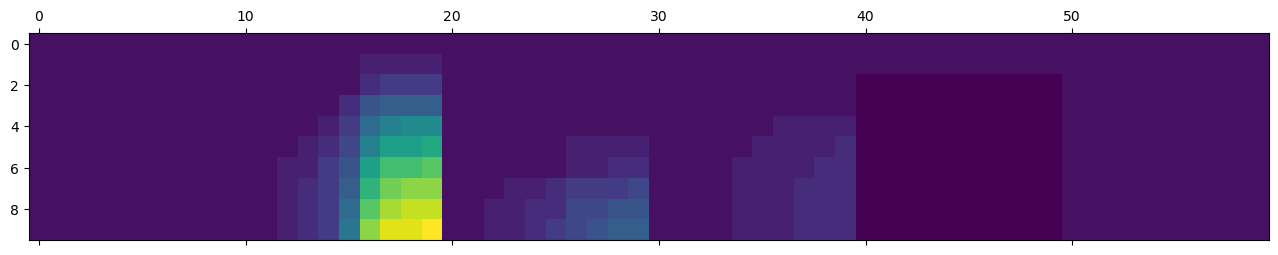

In [89]:
plt.matshow(np.hstack([f2[4, i, :, :] for i in range(6)]))

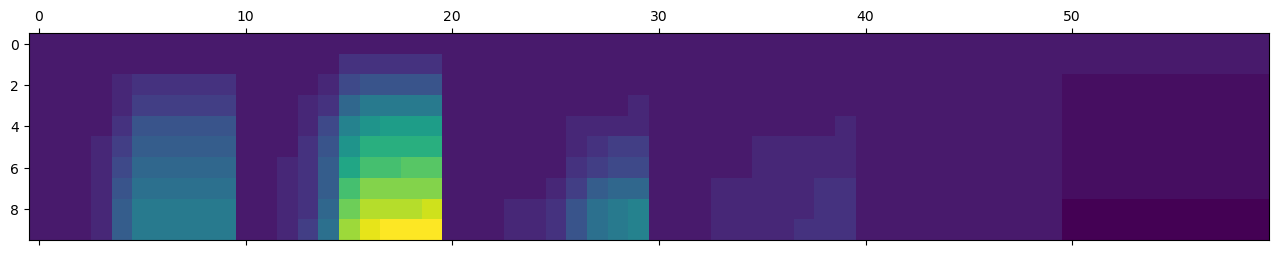

In [90]:
plt.matshow(np.hstack([f2[5, i, :, :] for i in range(6)]))

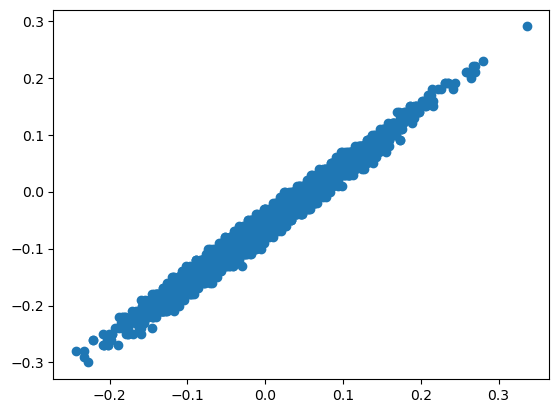

In [91]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))

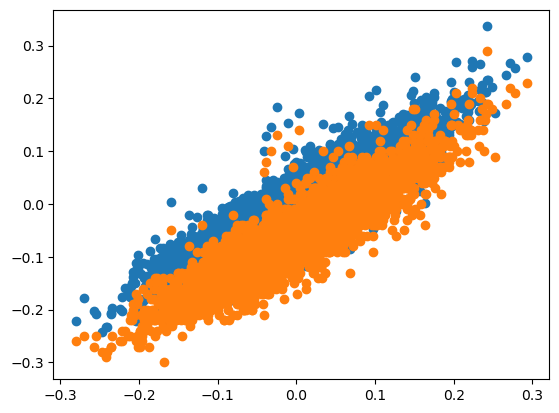

In [92]:
plt.scatter(ytv, lm.predict(Xtv))
plt.scatter(ytv, np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))

## Try rank-1 approx

In [93]:
# how well would a low-rank approx work?
def rk1approx(a):
    cm = np.mean(a, 0)
    rm = np.mean(a, 1)
    a2 = cm.reshape((10, 1)) * rm.reshape((1, 10))
    scale = np.max(a)/np.max(a2)
    a2 = scale * a2
    return a2

f0 = order0_fx
f1 = order1_fx
f2 = order2_fx

for i in range(6):
    for j in range(6):
        if np.max(np.abs(f2[i, j, :, :])) > 0.001:
            f2[i, j, :, :] = rk1approx(f2[i, j, :, :])
        else:
            f2[i, j, :, :] = 0

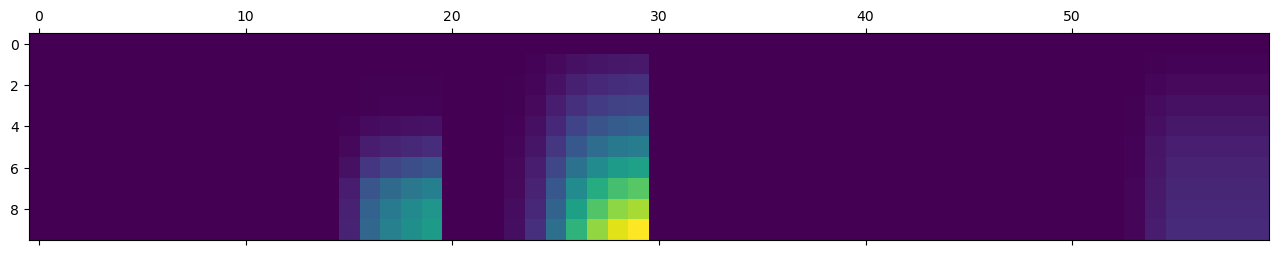

In [94]:
plt.matshow(np.hstack([f2[0, i, :, :] for i in range(6)]))

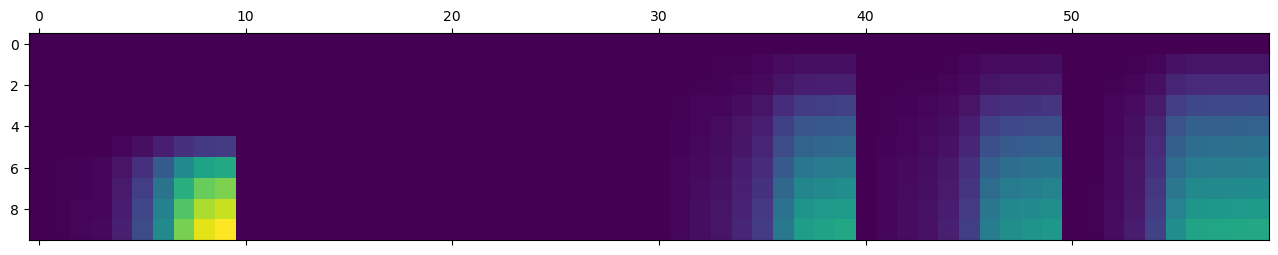

In [95]:
plt.matshow(np.hstack([f2[1, i, :, :] for i in range(6)]))

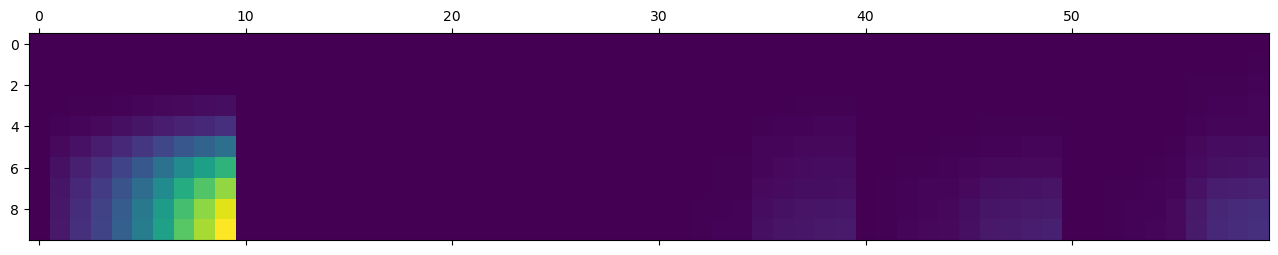

In [96]:
plt.matshow(np.hstack([f2[2, i, :, :] for i in range(6)]))

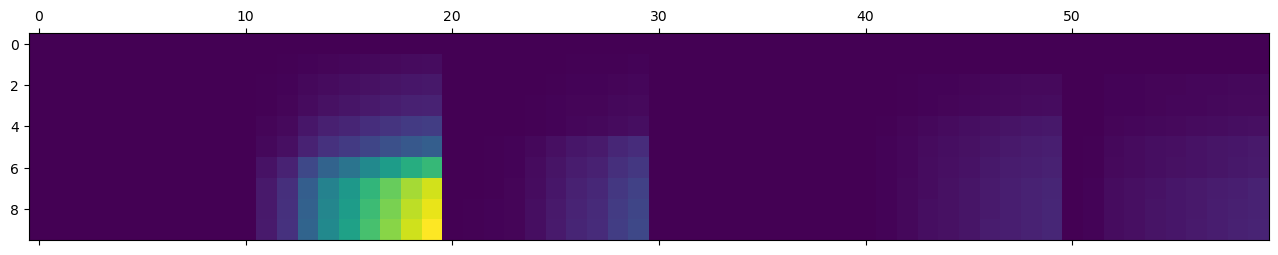

In [97]:
plt.matshow(np.hstack([f2[3, i, :, :] for i in range(6)]))

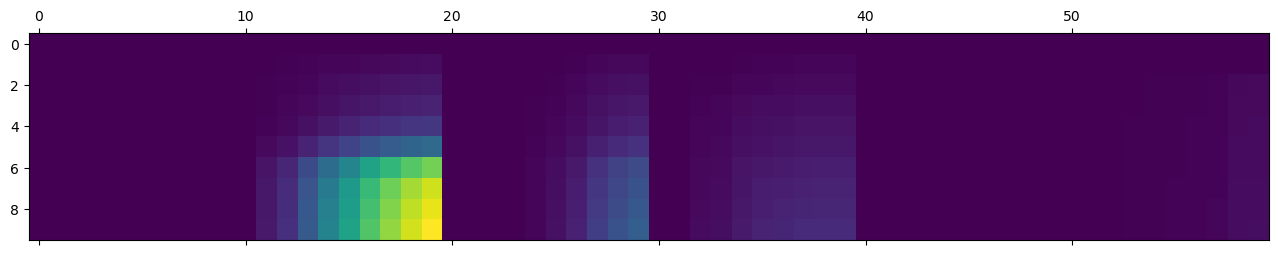

In [98]:
plt.matshow(np.hstack([f2[4, i, :, :] for i in range(6)]))

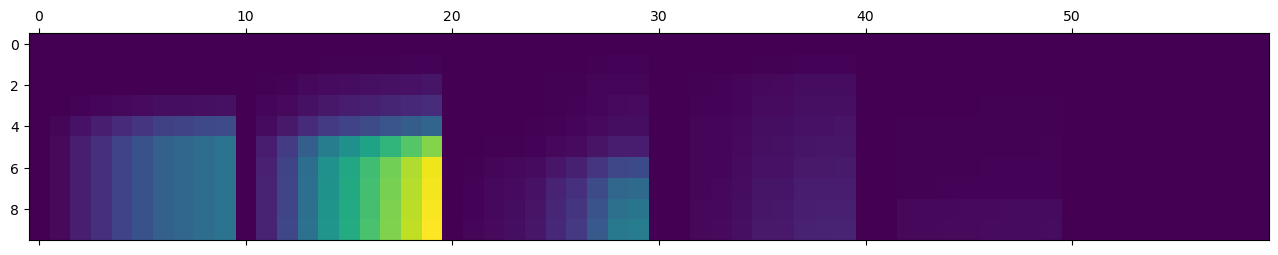

In [99]:
plt.matshow(np.hstack([f2[5, i, :, :] for i in range(6)]))

In [104]:
pearsonr(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))

PearsonRResult(statistic=0.33198186424708065, pvalue=1.3495815458203041e-89)

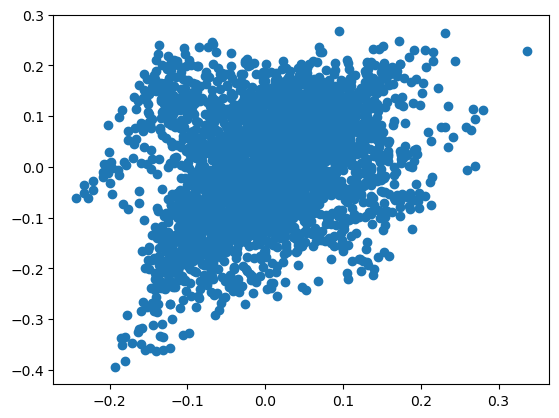

In [103]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))

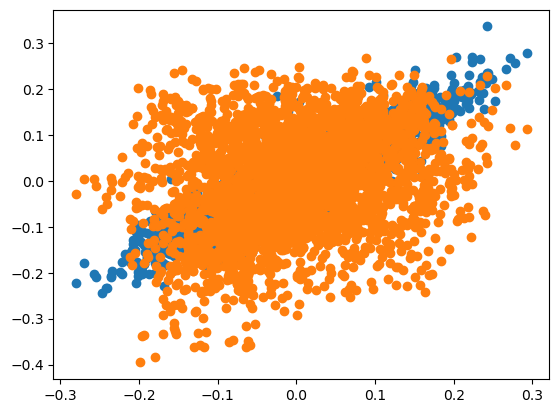

In [101]:
plt.scatter(ytv, lm.predict(Xtv))
plt.scatter(ytv, np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))